In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import vice
import apogee_analysis as aah
from astropy.table import Table
import plotting
import astropy as ap
import astropy.units as u

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
file_name = "allStar-dr17-synspec_rev1.fits"

In [4]:
ff = fits.open(file_name, mmap=True)
da = ff[1].data
ff.close()

In [5]:
# cuts in W+19
mask = da["LOGG"] > 1
mask &= da["LOGG"] < 2
mask &= da["SNR"] > 80
filtered = da[mask]
# del da

Text(0, 0.5, 'log g')

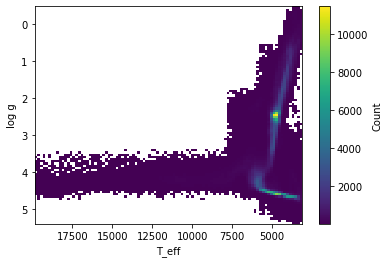

In [6]:
plotting.density_scatter(da["TEFF"], da["LOGG"], density=False)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("T_eff")
plt.ylabel("log g")

In [7]:
df = pd.DataFrame(filtered.tolist(), columns = [c.name for c in filtered.columns])

del filtered
del da

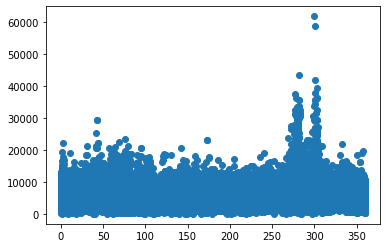

In [8]:
plt.scatter(df["GLON"], df["GAIAEDR3_R_MED_GEO"])

In [9]:
# Calculate galactocentric coordinates
import astropy.coordinates as coord
c = coord.SkyCoord(ra = df["RA"] * u.degree,
                           dec = df["DEC"] * u.degree,
                           distance = df["GAIAEDR3_R_MED_GEO"] * u.pc,
                           frame="icrs")
gc_c = c.transform_to(coord.Galactocentric)
df["R_gal"] = np.array(np.sqrt(gc_c.x**2 + gc_c.y**2) / 1e3)
df["th_gal"] = np.array(np.arctan(gc_c.y/gc_c.x))
df["abs_z"] = np.array(np.abs(gc_c.z) / 1e3)
df["z"] = np.array(gc_c.z / 1e3)


(-10.0, 10.0)

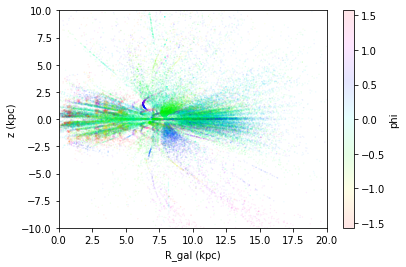

In [10]:
plt.scatter(df.R_gal, df.z, c=df.th_gal, s=0.1, alpha=0.1, cmap="hsv")
plt.colorbar(label="phi")
plt.xlabel("R_gal (kpc)")
plt.ylabel("z (kpc)")
plt.xlim(0, 20)
plt.ylim(-10, 10)

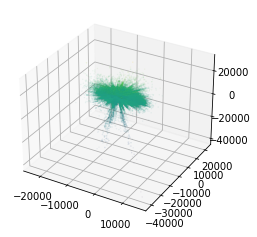

In [11]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(gc_c.x, gc_c.y, gc_c.z, s=0.1, alpha=0.1, c=gc_c.z)

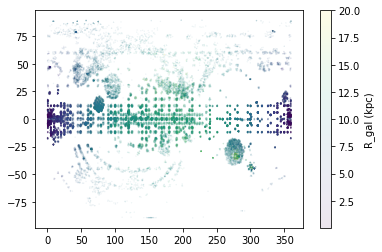

In [12]:
plt.scatter(df["GLON"], df["GLAT"], c=df.R_gal, s=0.1, alpha=0.1, vmax=20)
plt.colorbar(label="R_gal (kpc)")

In [13]:
def bracket(df, ele, ele2="H"):
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


In [14]:
def bracket_to_abundance(data, ele):
    return 10**data * vice.solar_z(ele)
def abundance_to_bracket(data, ele):
    return np.log10(data/vice.solar_z(ele))

In [15]:
df["O_H"] = bracket(df, "O")
df["C_O"] = bracket(df, "C", "O")
df["C_N"] = bracket(df, "C", "N")
df["C_H"] = bracket(df, "C", "H")
df["N_H"] = bracket(df, "N", "H")

In [16]:
df["CN_H"] = np.log10((
    bracket_to_abundance(df["C_H"], "C") +
    bracket_to_abundance(df["N_H"], "N"))
    / (vice.solar_z("C") + vice.solar_z("N")))

In [17]:
df["C-N_H"] = np.log10((
    bracket_to_abundance(df["C_H"], "C") -
    bracket_to_abundance(df["N_H"], "N"))
    / (vice.solar_z("C") + vice.solar_z("N")))

/home/daniel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


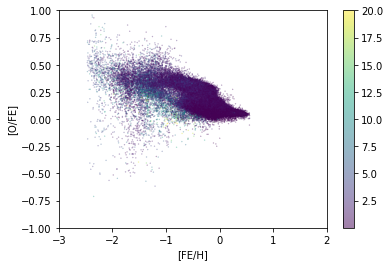

In [18]:
plt.scatter(df["FE_H"], df["O_FE"], c=df.abs_z, s=0.1, alpha=0.5, vmax=20)
plt.ylim(-1,1)
plt.xlim(-3,2)
plt.ylabel("[O/FE]")
plt.xlabel("[FE/H]")
plt.colorbar()

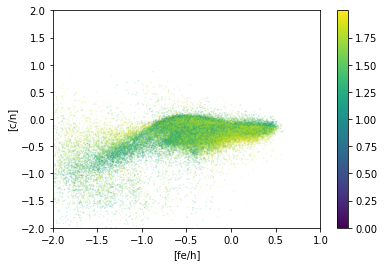

In [19]:
plt.scatter(df["FE_H"], df["C_N"], s=0.01, c=df["LOGG"], vmin=0)
plt.xlim(-2, 1)
plt.ylim(-2, 2)
plt.xlabel("[fe/h]")
plt.ylabel("[c/n]")
plt.colorbar()

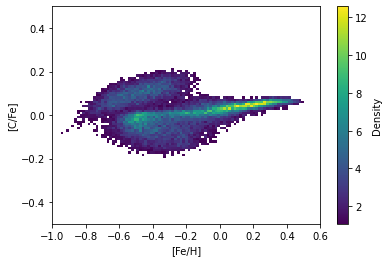

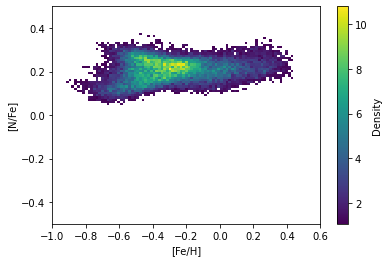

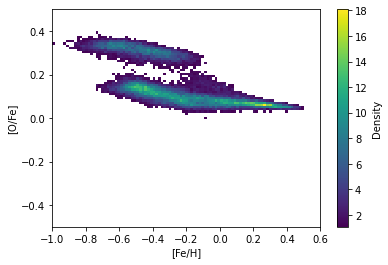

In [20]:
xlim = (-1, 0.6)
for ele in ["C", "N", "O"]:
    plotting.density_scatter(df["FE_H"], df["%s_FE" % ele], xlim=xlim, ylim=(-0.5, 0.5))
    plt.xlabel("[Fe/H]")
    plt.ylabel("[%s/Fe]" % ele)
    plt.show()

In [ ]:
# [O/Mg] on y-axis and [Mg/H] on x-axis, flat in APOGEE, negative slope in GALAH

In [109]:
from sklearn.cluster import dbscan

In [110]:
filt_na = ~df[["FE_H", "O_FE"]].isna().any(axis=1)

In [121]:
core_samples, labels = dbscan(df[["FE_H", "O_FE"]][filt_na], eps=0.01, min_samples=60)

In [125]:
filt = (labels == 1) | (labels == 0)
split = df[filt_na].iloc[filt]
split["hi_alpha"] = labels[filt] == 1

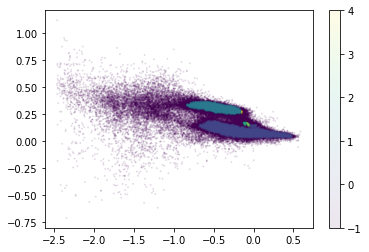

In [22]:
plt.scatter(df["FE_H"][filt_na], df["O_FE"][filt_na], c=labels, s=1, alpha=0.1)
plt.colorbar()

Results of clusters using dbscan 

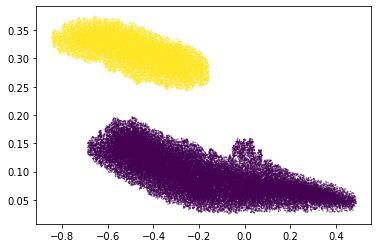

In [23]:
plt.scatter(split["FE_H"], split["O_FE"], c=split.hi_alpha, s=0.1)

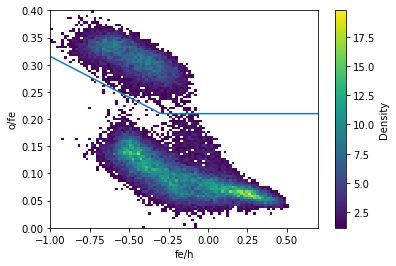

In [24]:

def o_fe_fe_h_cutoff(fe_h):
    return 0.21 - 0.15*(fe_h + 0.3) *(fe_h < -0.3)

plotting.density_scatter(df["FE_H"], df["O_FE"], xlim=(-1,0.7), ylim=(0, 0.4))
plt.xlabel("fe/h")
plt.ylabel('o/fe')
x = np.linspace(-1, 0.7)
y = o_fe_fe_h_cutoff(x)

plt.plot(x, y)

Plot of the o/fe-fe/h bimodality in apogee data

In [ ]:
plt.scatter(df["O_H"], df["CN_H"] - df["O_H"], s=0.1)


Text(0, 0.5, '[C+N/O]')

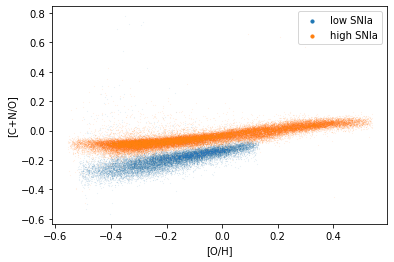

In [115]:
s = 0.001
x_vals = split["O_H"]
y_vals = split["CN_H"] - split["O_H"]
plt.scatter(x_vals[split.hi_alpha], y_vals[split.hi_alpha], label="low SNIa", alpha=1, s=s)
plt.scatter(x_vals[~split.hi_alpha], y_vals[~split.hi_alpha], label="high SNIa", alpha=1, s=s)
plt.legend(markerscale=0.1/s)
plt.xlabel("[O/H]")
plt.ylabel("[C+N/O]")


Text(0, 0.5, '[C-N/O]')

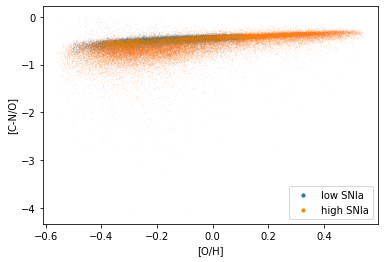

In [126]:
s = 0.001
x_vals = split["O_H"]
y_vals = split["C-N_H"] - split["O_H"]
plt.scatter(x_vals[split.hi_alpha], y_vals[split.hi_alpha], label="low SNIa", alpha=1, s=s)
plt.scatter(x_vals[~split.hi_alpha], y_vals[~split.hi_alpha], label="high SNIa", alpha=1, s=s)
plt.legend(markerscale=0.1/s)
plt.xlabel("[O/H]")
plt.ylabel("[C-N/O]")

(-2.0, 0.7)

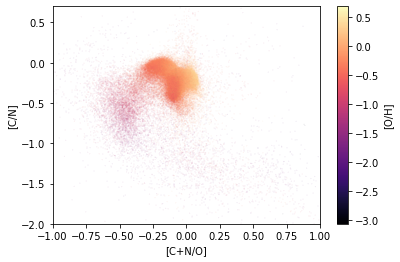

In [119]:
s = 0.001
y_vals = df["C_N"]
x_vals = df["CN_H"] - df["O_H"]
plt.scatter(x_vals, y_vals, c=df["O_H"], alpha=1, s=s, cmap="magma")
plt.colorbar(label="[O/H]")
plt.ylabel("[C/N]")
plt.xlabel("[C+N/O]")
plt.xlim(-1, 1)
plt.ylim(-2, 0.7)

In [25]:
def plot_abundance_alpha(x="O_H", y="C_O", df=split, fig=None, ax=None, s=0.001):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        
    x_vals = bracket(df, *x.split("_"))
    y_vals = bracket(df, *y.split("_"))
    ax.scatter(x_vals[df.hi_alpha], y_vals[df.hi_alpha], label="low SNIa", alpha=1, s=s)
    ax.scatter(x_vals[~df.hi_alpha], y_vals[~df.hi_alpha], label="high SNIa", alpha=1, s=s)
    ax.legend(markerscale=0.1/s)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    

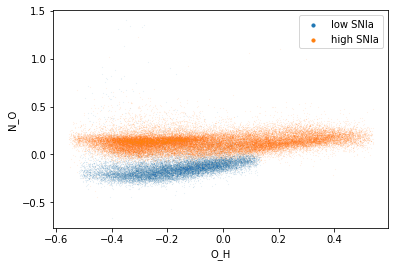

In [26]:
plot_abundance_alpha(y="N_O")

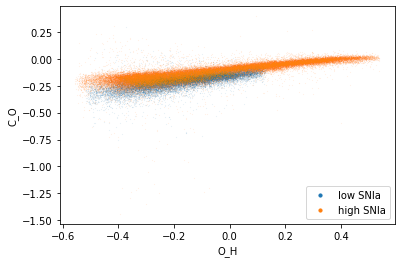

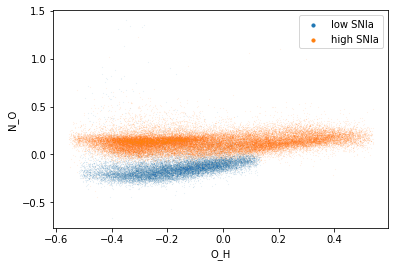

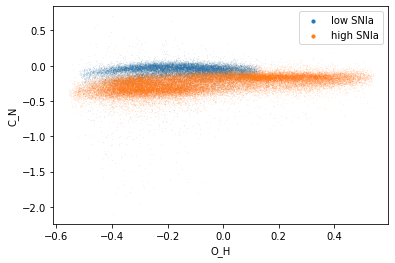

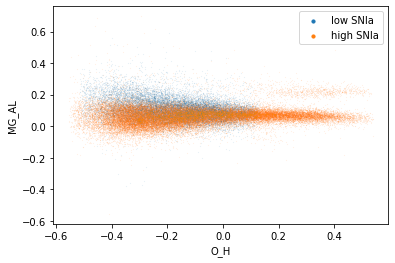

In [84]:
plot_abundance_alpha()
plt.show()

plot_abundance_alpha(y="N_O")
plt.show()

plot_abundance_alpha(y="C_N")
plt.show()

plot_abundance_alpha(y="MG_AL")

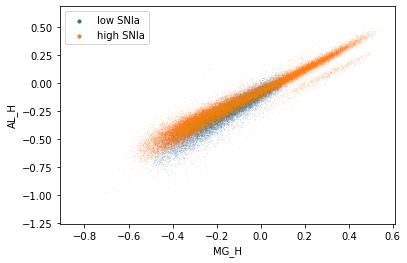

In [89]:
plot_abundance_alpha(x = "MG_H", y = "AL_H")

In [79]:
def plot_in_gal_region(x="O_H", y="C_O", xlabel=None, ylabel=None):
    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(20,15))
    for j in range(5):
        R_min, R_max = [(1, 3), (3, 5), (5,7), (7,9), (9,11), (11,13)][j]
    

        for i in range(3):
            z_min, z_max = [(0, 0.5), (0.5, 1), (1, 2)][i]
            ax = axs[j][i]
            mask = split.R_gal > R_min
            mask &= split.R_gal < R_max
            mask &= split.abs_z > z_min
            mask &= split.abs_z < z_max
            
            # plotting.density_scatter(x[mask], y[mask], fig=fig, ax=ax)
            plot_abundance_alpha(x, y, df = split[mask], fig=fig, ax=ax, s=0.01)
            ax.set_xlabel("")
            ax.set_ylabel("")
            if j==0:
                ax.set(title="z =  %1.1f - %1.1f" % (z_min, z_max))
            if i == 0:
                ax.set_ylabel("R = %i - %i" %(R_min, R_max))
                

                
    fig.supxlabel("[%s/%s]" % tuple(x.split("_")))
    fig.supylabel("[%s/%s]" % tuple(y.split("_")))
            
            


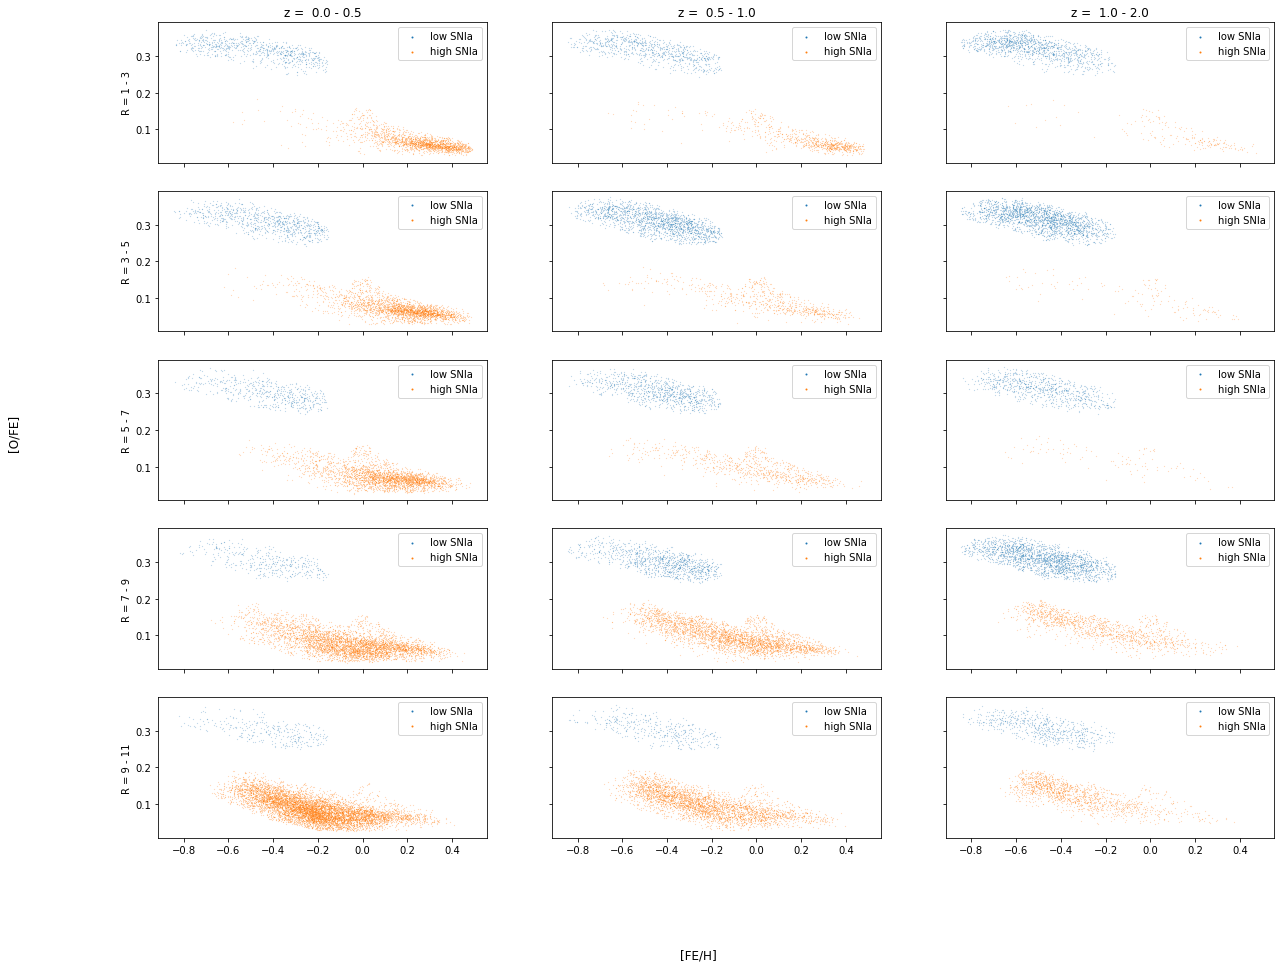

In [80]:
plot_in_gal_region(x = "FE_H", y="O_FE")

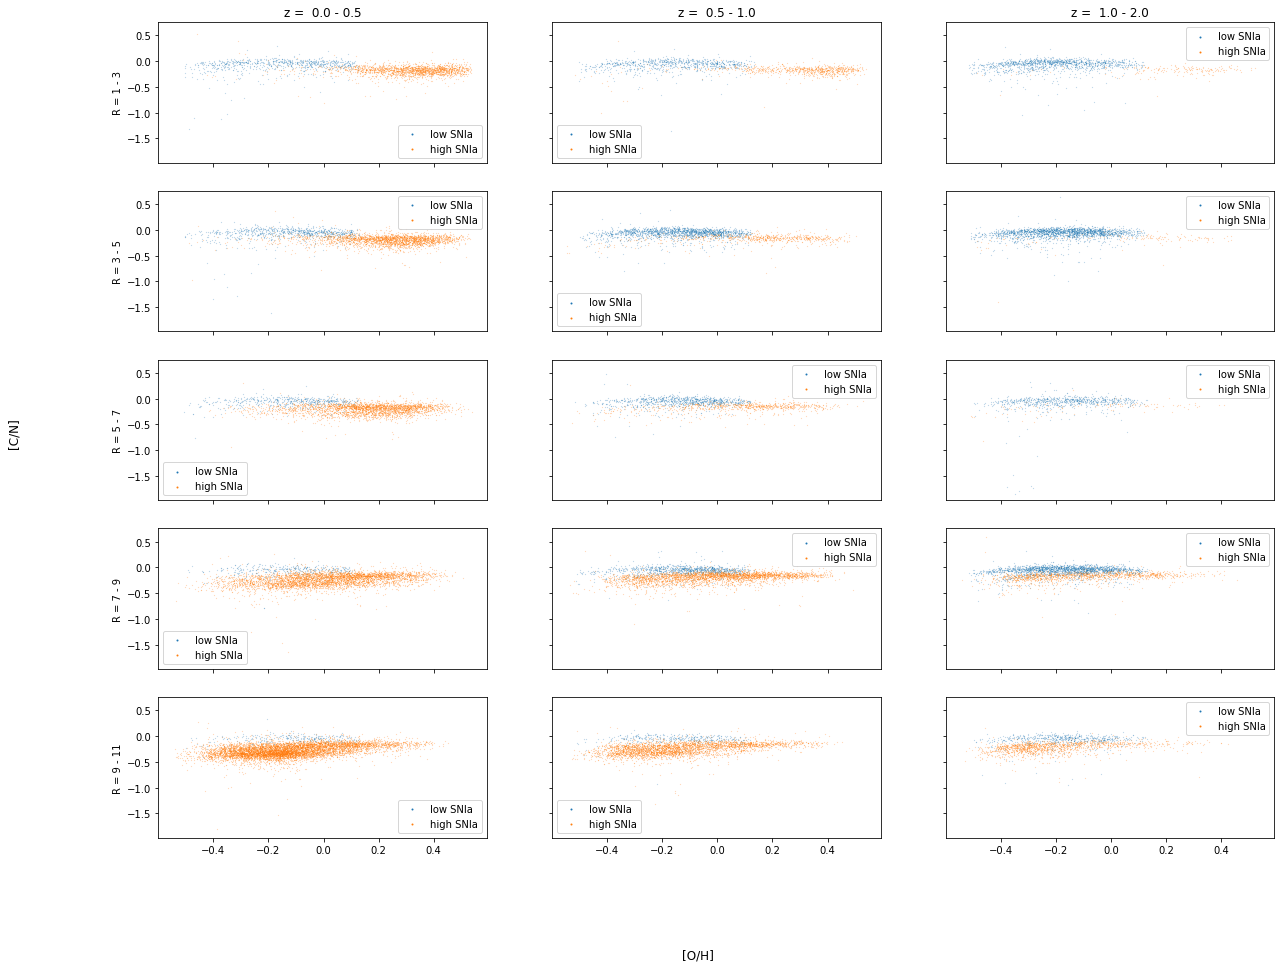

In [81]:
plot_in_gal_region(y="C_N")

Plots of C/N vs O/H in different galactic regions 

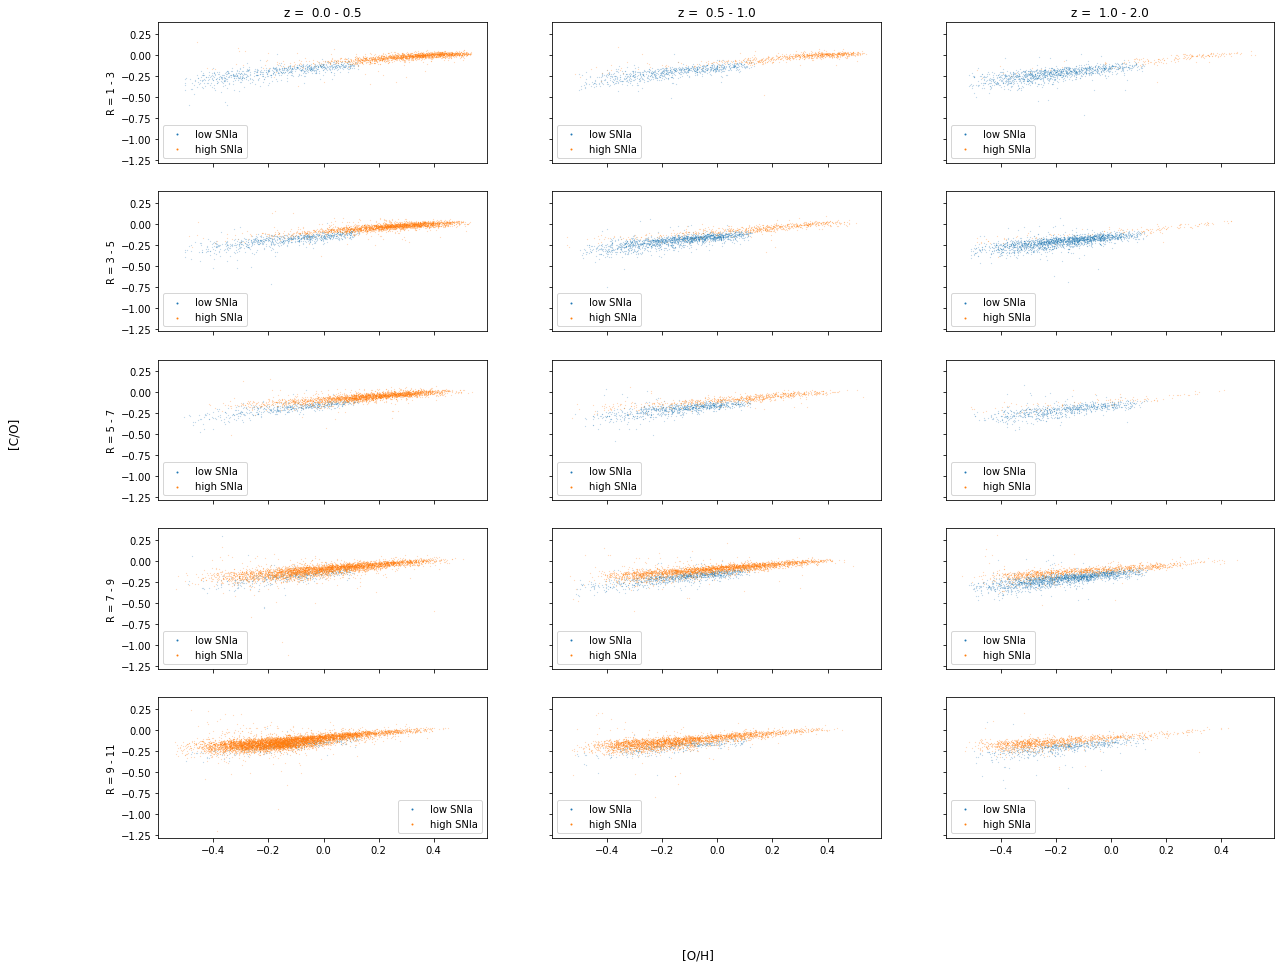

In [82]:
plot_in_gal_region(y="C_O")

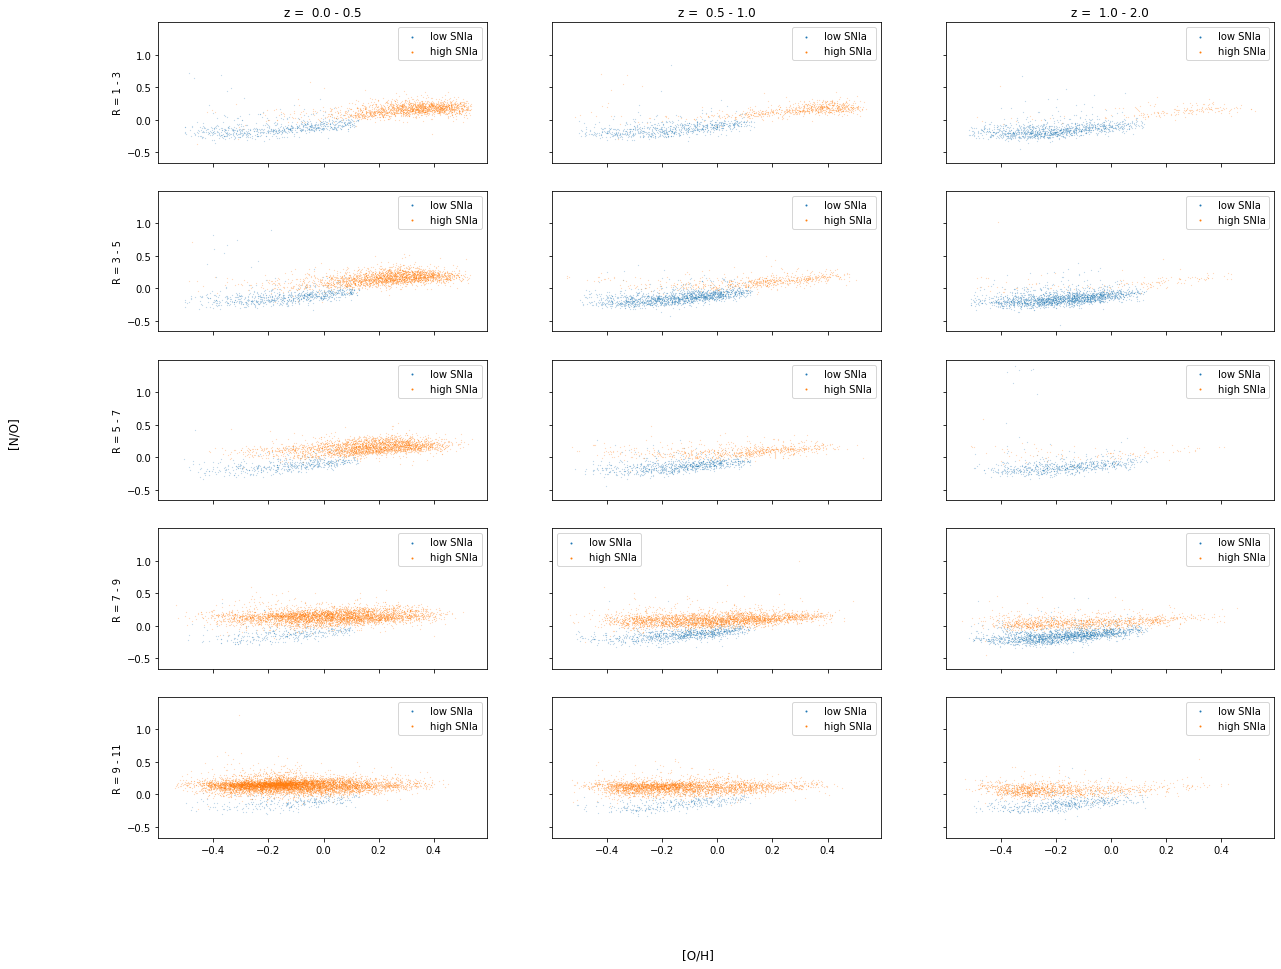

In [83]:
plot_in_gal_region(y="N_O")

In [33]:
v21 = aah.vincenzo2021()

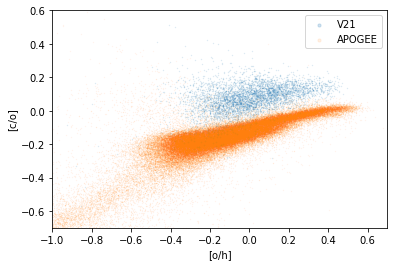

In [34]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=0.1, alpha=0.2, label="V21")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")
plt.scatter(df["O_H"], df["C_O"], s=0.1, alpha=0.1, label="APOGEE")
plt.xlim(-1,0.7)
plt.ylim(-0.7, 0.6)
plt.legend(markerscale=10)

(array([4., 3., 1., 0., 1., 0., 0., 0., 1., 1.]),
 array([ 1.50200021, 10.95243648, 20.40287275, 29.85330902, 39.30374529,
        48.75418156, 58.20461783, 67.6550541 , 77.10549037, 86.55592664,
        96.00636292]),
 <BarContainer object of 10 artists>)

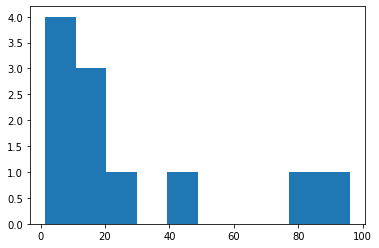

In [35]:
plt.hist(df["VSINI"][df["VSINI"] > 0])

Text(0, 0.5, '[c/o]')

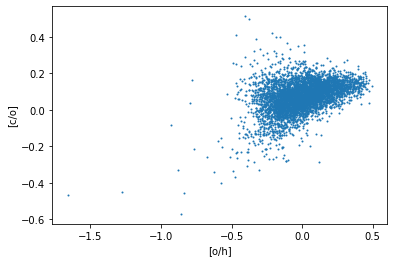

In [36]:
plt.scatter(v21["[o/h]"], v21["[c/o]"], s=1)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

Text(0, 0.5, '[C/N]')

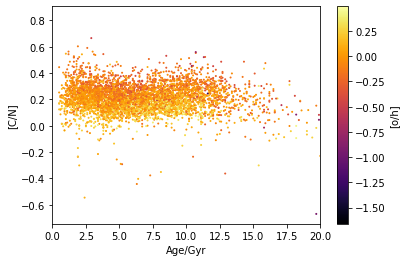

In [57]:
plt.scatter(v21["age"], v21["[c/n]"], s=1, c=v21["[o/h]"], cmap="inferno")
plt.xlim(0, 20)
plt.colorbar(label="[o/h]")
plt.xlabel("Age/Gyr")
plt.ylabel("[C/N]")

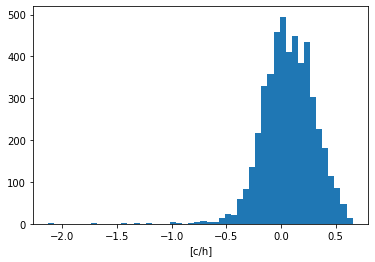

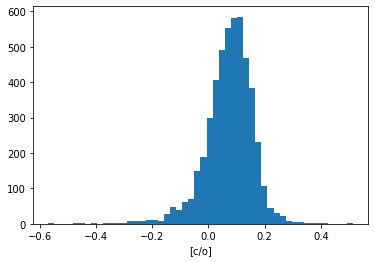

Text(0.5, 0, '[c/n]')

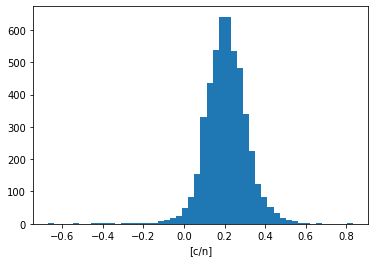

In [61]:
plt.hist(v21["[c/h]"], 50)
plt.xlabel("[c/h]")
plt.show()

plt.hist(v21["[c/o]"], 50)
plt.xlabel("[c/o]")
plt.show()

plt.hist(v21["[c/n]"], 50)
plt.xlabel("[c/n]")


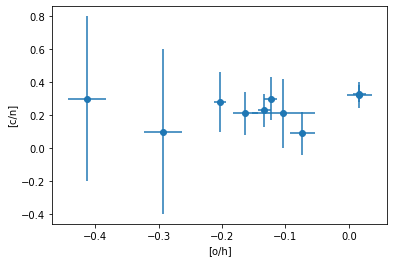

Text(0, 0.5, '[c/o]')

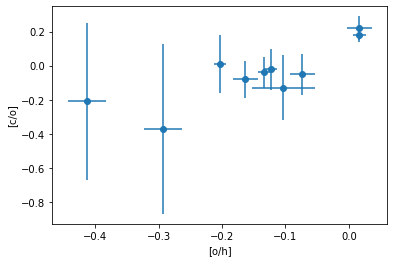

In [37]:
# rom skillman 2020, table 2
# https://ui.adsabs.harvard.edu/abs/2020ApJ...894..138S/abstract

aah.plot_skillman20_cnoh()
plt.xlabel("[o/h]")
plt.ylabel("[c/n]")
plt.show()
aah.plot_skillman20_cooh()
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

Text(0, 0.5, '[c/o]')

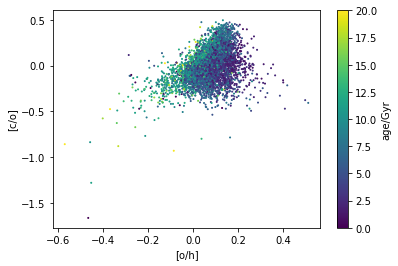

In [38]:
plt.scatter(v21["[c/o]"] , v21["[o/h]"], c=v21["age"], vmin=0, s=1)
plt.colorbar(label="age/Gyr")
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

In [128]:
v21["[cn/h]"] = np.log10((
    bracket_to_abundance(v21["[c/h]"], "C") +
    bracket_to_abundance(v21["[n/h]"], "N"))
    / (vice.solar_z("C") + vice.solar_z("N")))

v21["[c-n/h]"] = np.log10((
    bracket_to_abundance(v21["[c/h]"], "C") -
    bracket_to_abundance(v21["[n/h]"], "N"))
    / (vice.solar_z("C") + vice.solar_z("N")))

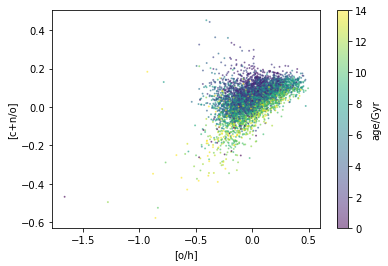

In [138]:
plt.scatter(v21["[o/h]"], v21["[cn/h]"] - v21["[o/h]"], c=v21["age"], vmin=0, vmax=14, s=1, alpha=0.5)
plt.xlabel("[o/h]")
plt.ylabel("[c+n/o]")
plt.colorbar(label="age/Gyr")

(0.0, 15.0)

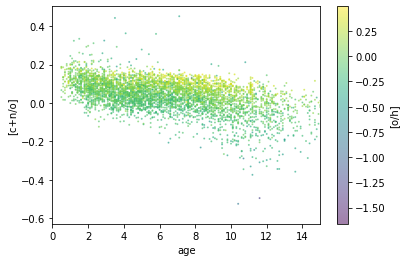

In [146]:
plt.scatter(v21["age"], v21["[cn/h]"] - v21["[o/h]"], c=v21["[o/h]"], s=1, alpha=0.5)
plt.xlabel("age")
plt.ylabel("[c+n/o]")
plt.colorbar(label="[o/h]")
plt.xlim(0, 15)

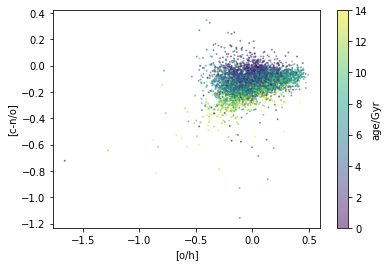

In [145]:
plt.scatter(v21["[o/h]"], v21["[c-n/h]"] - v21["[o/h]"], c=v21["age"], vmin=0, vmax=14, s=1, alpha=0.5)
plt.xlabel("[o/h]")
plt.ylabel("[c-n/o]")
plt.colorbar(label="age/Gyr")

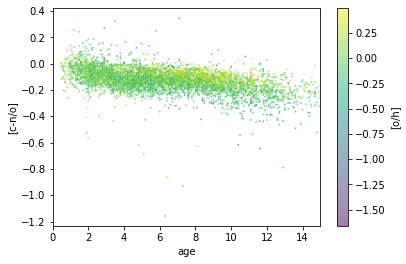

In [144]:
plt.scatter(v21["age"], v21["[c-n/h]"] - v21["[o/h]"], c=v21["[o/h]"], s=1, alpha=0.5)
plt.xlabel("age")
plt.ylabel("[c-n/o]")
plt.xlim(0, 15)
plt.colorbar(label="[o/h]")

# Quantifying scatter

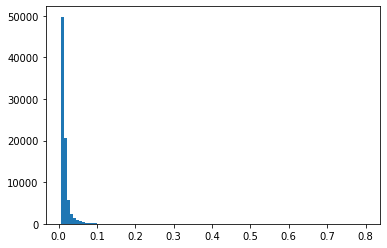

In [32]:
plt.hist(df["O_FE_ERR"], 100);

(0.0, 1.0)

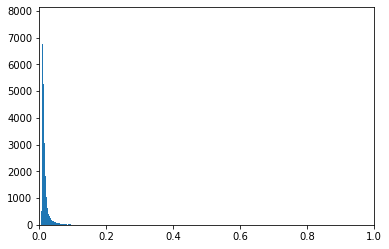

In [38]:
plt.hist(df["O_FE_ERR"], 1000);
plt.xlim(0, 1)

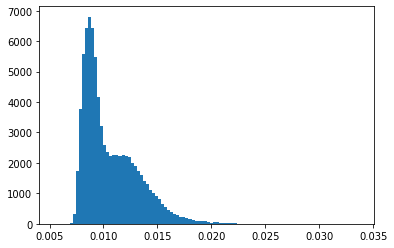

In [37]:
plt.hist(df["FE_H_ERR"], 100);

# MultiProcess Model

Trying to apply methods from W+19 to AGB star yields. 